Portfolio Project by Muhammad Rayhan Nur

# 📦Install and Import Dependencies

In [ ]:
!pip install transformers requests beautifulsoup4 pandas numpy wordcloud matplotlib

In [ ]:
from transformers import BertTokenizer, BertForSequenceClassification, Trainer, TrainingArguments
from torch.utils.data import Dataset
from wordcloud import WordCloud
from bs4 import BeautifulSoup
from sklearn.model_selection import train_test_split
import torch
import requests
import re
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# 🗎 Import Data

## Download Dataset

The dataset source is [here](https://www.kaggle.com/datasets/charitarth/semeval-2014-task-4-aspectbasedsentimentanalysis)

In [ ]:
import kagglehub

path = kagglehub.dataset_download("charitarth/semeval-2014-task-4-aspectbasedsentimentanalysis")

print("Path to dataset files:", path)

Path to dataset files: /root/.cache/kagglehub/datasets/charitarth/semeval-2014-task-4-aspectbasedsentimentanalysis/versions/4


## Load Dataset

In [ ]:
df_laptop = pd.read_csv('/root/.cache/kagglehub/datasets/charitarth/semeval-2014-task-4-aspectbasedsentimentanalysis/versions/4/Laptop_Train_v2.csv')
df_laptop.head()

,id,Sentence,Aspect Term,polarity,from,to
0,2339,I charge it at night and skip taking the cord ...,cord,neutral,41,45
1,2339,I charge it at night and skip taking the cord ...,battery life,positive,74,86
2,1316,The tech guy then said the service center does...,service center,negative,27,41
3,1316,The tech guy then said the service center does...,"""sales"" team",negative,109,121
4,1316,The tech guy then said the service center does...,tech guy,neutral,4,12


## Explore Dataset

In [ ]:
df_laptop.shape

(2358, 6)

In [ ]:
df_laptop = df_laptop.drop_duplicates(subset='Sentence')
df_laptop = df_laptop.reset_index(drop=True)

df_laptop.shape

(1482, 6)

In [ ]:
df_laptop.head()

,id,Sentence,Aspect Term,polarity,from,to
0,2339,I charge it at night and skip taking the cord ...,cord,neutral,41,45
1,1316,The tech guy then said the service center does...,service center,negative,27,41
2,2005,"it is of high quality, has a killer GUI, is ex...",quality,positive,14,21
3,2789,Easy to start up and does not overheat as much...,start up,positive,8,16
4,76,"I even got my teenage son one, because of the ...",features,positive,46,54


### Group Data by Polarity for Visualization

<ipython-input-283-81945b51e338>:16: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=grouped_data_by_polarity, x='polarity', y='count', palette=color_mapping)


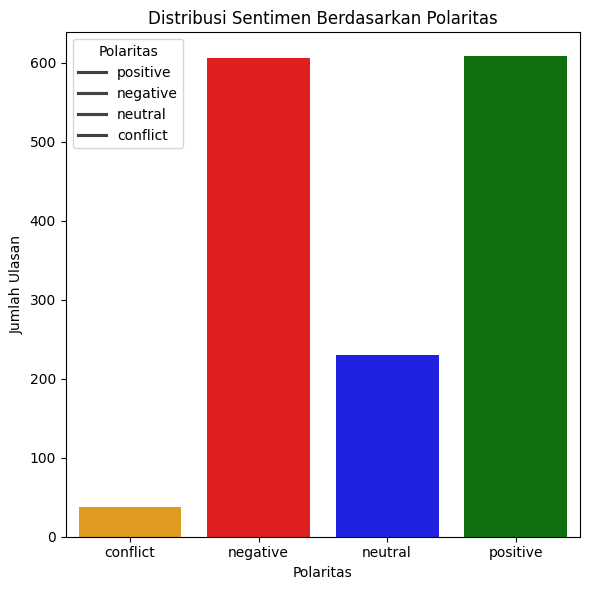

In [ ]:
grouped_data_by_polarity = df_laptop.groupby(['polarity']).size().reset_index(name='count')

color_mapping = {
    'positive': 'green',
    'negative': 'red',
    'neutral': 'blue',
    'conflict': 'orange'
}

plt.figure(figsize=(6, 6))

sns.barplot(data=grouped_data_by_polarity, x='polarity', y='count', palette=color_mapping)


plt.title('Distribusi Sentimen Berdasarkan Polaritas')
plt.xlabel('Polaritas')
plt.ylabel('Jumlah Ulasan')
plt.legend(title='Polaritas', labels=color_mapping.keys())
plt.tight_layout()

plt.show()

### Group Data by Aspect Term for Visualization

In [ ]:
print(df_laptop['Aspect Term'].unique())

['cord' 'service center' 'quality' 'start up' 'features' 'GUI' 'battery'
 'rubber enclosure' 'multi-touch gestures' 'suite of software' 'speed'
 'Windows 7' 'usb devices' 'keyboard' 'software'
 'Microsoft office for the mac' 'syncing' '30" HD Monitor' 'boot up'
 'service' 'operating system' 'price' 'clock in BIOS setup'
 'WARRANTY SERVICE' 'brand' 'warranty' 'fan' 'Customer Service number'
 'hard disc' 'Drivers' 'HP Technical Support' 'browser' 'virus scan'
 '9 punds' 'program' 'warrenty' 'Toshiba Warranty' 'Quality' 'webcam'
 'internet' 'motherboard' 'system' 'charger' 'force quit' 'works'
 'extended warranty' 'memory' 'opening my Documents folder'
 'operating systems' 'glass touchpad' 'hard drive' 'external speaker'
 'battery life' 'hardware' 'shipping' 'Mac software' 'delete  key' 'use'
 'recovery discs' 'Office Max\'s "Max Assurance"' 'iMac backup disc'
 'battery timer' 'Temperatures' 'virus protection for Mac' 'bluetooth'
 'LG notebook service center' 'games' 'responds'
 'represen

In [ ]:
print(len(df_laptop['Aspect Term'].unique()))

700


In [ ]:
# Mengelompokkan data berdasarkan Aspek
grouped_data_by_aspect = df_laptop.groupby(['Aspect Term']).size().reset_index(name='count')
grouped_data_by_aspect.sort_values(by='count', ascending=False).head(10)

,Aspect Term,count
550,screen,45
231,battery life,38
499,price,36
230,battery,36
648,use,28
410,keyboard,26
668,warranty,25
337,features,23
512,programs,23
579,software,21


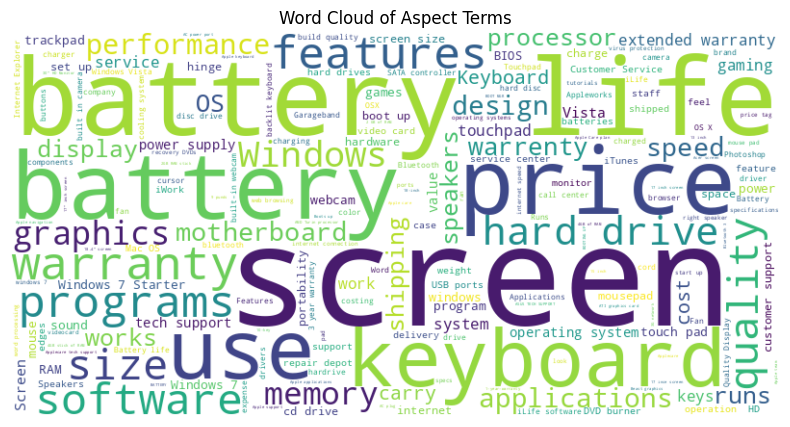

In [ ]:
# Create a dictionary for word cloud
word_freq = dict(zip(grouped_data_by_aspect['Aspect Term'], grouped_data_by_aspect['count']))

# Create a word cloud
wordcloud = WordCloud(width=800, height=400, background_color='white').generate_from_frequencies(word_freq)

# Display the word cloud
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')  # Turn off the axis
plt.title('Word Cloud of Aspect Terms')
plt.show()

#🧹Data Preprocessing

## Cleaning the Data

In [ ]:
df_preprocess = df_laptop[['Sentence', 'Aspect Term', 'polarity']].copy()

df_preprocess.rename(columns={
    'Sentence': 'sentence',
    'Aspect Term': 'aspect',
    'polarity': 'polarity'
}, inplace=True)

df_preprocess.head()

,sentence,aspect,polarity
0,I charge it at night and skip taking the cord ...,cord,neutral
1,The tech guy then said the service center does...,service center,negative
2,"it is of high quality, has a killer GUI, is ex...",quality,positive
3,Easy to start up and does not overheat as much...,start up,positive
4,"I even got my teenage son one, because of the ...",features,positive


In [ ]:
grouped_data_by_polarity = df_preprocess.groupby(['polarity']).size().reset_index(name='count')
grouped_data_by_polarity.sort_values(by='count')

,polarity,count
0,conflict,38
2,neutral,230
1,negative,606
3,positive,608


In [ ]:
conflict_sentences = df_preprocess[df_preprocess['polarity'] == 'conflict']['sentence']

print("Sentences with 'conflict' polarity:")
for sentence in conflict_sentences:
    print(sentence)

Sentences with 'conflict' polarity:
-No backlit keyboard, but not an issue for me.
I did have to replace the battery once, but that was only a couple months ago and it's been working perfect ever since.
It has no camera but, I can always buy and install one easy.
Small screen somewhat limiting but great for travel.
A longer battery life would have been great - but it meets it's spec quite easily.
The Apple will run Internet Explorer, but at an amazingly slow rate.
The macbook rarely requires a hard reboot.
When we bought our new HP comouter in Dec. of 2008, we wanted Windows XP, but were told it would cost an extra $159, so we went with Vista.
But see the macbook pro is different because it may have a huge price tag but it comes with the full software that you would actually need and most of it has free future updates.
Despite the inconvenient weight, I opted for the 12 cell battery.
It is a big big, but since it has a 18.4" screen what would you expect!
Beta had better quality, but VH

In [ ]:
# Drop the rows with polarity is 'conflict' because the sentiments are mixed
df_preprocess = df_preprocess[df_preprocess['polarity'] != 'conflict']
df_preprocess['polarity'].unique()

array(['neutral', 'negative', 'positive'], dtype=object)

In [ ]:
grouped_data_by_polarity = df_preprocess.groupby(['polarity']).size().reset_index(name='count')
grouped_data_by_polarity.sort_values(by='count')

,polarity,count
1,neutral,230
0,negative,606
2,positive,608


In [ ]:
df_preprocess.isna().sum()

,0
sentence,0
aspect,0
polarity,0


In [ ]:
# Mapping of terms to their respective aspects (Using ChatGPT to help me)
aspect_mapping = {
    'cord': 'Power and Charging',
    'service center': 'Customer Service and Support',
    'quality': 'Build Quality',
    'start up': 'Performance',
    'features': 'Miscellaneous Features',
    'GUI': 'Software and Operating System',
    'battery': 'Battery and Power',
    'rubber enclosure': 'Build Quality',
    'multi-touch gestures': 'Keyboard and Input Devices',
    'suite of software': 'Software and Operating System',
    'speed': 'Performance',
    'Windows 7': 'Software and Operating System',
    'usb devices': 'Connectivity and Ports',
    'keyboard': 'Keyboard and Input Devices',
    'software': 'Software and Operating System',
    'Microsoft office for the mac': 'Software and Operating System',
    'syncing': 'Software and Operating System',
    '30" HD Monitor': 'Display and Graphics',
    'boot up': 'Performance',
    'service': 'Customer Service and Support',
    'operating system': 'Software and Operating System',
    'price': 'Value for Money',
    'clock in BIOS setup': 'Performance',
    'WARRANTY SERVICE': 'Customer Service and Support',
    'brand': 'Value for Money',
    'warranty': 'Customer Service and Support',
    'fan': 'Cooling System',
    'Customer Service number': 'Customer Service and Support',
    'hard disc': 'Storage and Memory',
    'Drivers': 'Software and Operating System',
    'HP Technical Support': 'Customer Service and Support',
    'browser': 'Software and Operating System',
    'virus scan': 'Software and Operating System',
    '9 punds': 'Portability',
    'program': 'Software and Operating System',
    'warrenty': 'Customer Service and Support',
    'Toshiba Warranty': 'Customer Service and Support',
    'Quality': 'Build Quality',
    'webcam': 'Miscellaneous Features',
    'internet': 'Connectivity and Ports',
    'motherboard': 'Hardware',
    'system': 'Performance',
    'charger': 'Power and Charging',
    'force quit': 'Software and Operating System',
    'works': 'Performance',
    'extended warranty': 'Customer Service and Support',
    'memory': 'Storage and Memory',
    'opening my Documents folder': 'Software and Operating System',
    'operating systems': 'Software and Operating System',
    'glass touchpad': 'Keyboard and Input Devices',
    'hard drive': 'Storage and Memory',
    'external speaker': 'Miscellaneous Features',
    'battery life': 'Battery and Power',
    'hardware': 'Hardware',
    'shipping': 'Customer Service and Support',
    'Mac software': 'Software and Operating System',
    'delete key': 'Keyboard and Input Devices',
    'use': 'Miscellaneous Features',
    'recovery discs': 'Software and Operating System',
    'Office Max\'s "Max Assurance"': 'Customer Service and Support',
    'iMac backup disc': 'Software and Operating System',
    'battery timer': 'Battery and Power',
    'Temperatures': 'Cooling System',
    'virus protection for Mac': 'Software and Operating System',
    'bluetooth': 'Connectivity and Ports',
    'LG notebook service center': 'Customer Service and Support',
    'games': 'Miscellaneous Features',
    'responds': 'Performance',
    'representive at Microsoft': 'Customer Service and Support',
    'WIndows 7': 'Software and Operating System',
    'Keyboard': 'Keyboard and Input Devices',
    "Dell's customer disservice": 'Customer Service and Support',
    'cooling system': 'Cooling System',
    'quad core I7': 'Performance',
    'sales associate': 'Customer Service and Support',
    'virus program': 'Software and Operating System',
    'weighed': 'Portability',
    'bag': 'Portability',
    'color': 'Design and Build Quality',
    'keys': 'Keyboard and Input Devices',
    'style': 'Design and Build Quality',
    'mousepad': 'Keyboard and Input Devices',
    'sales': 'Customer Service and Support',
    'touch pad': 'Keyboard and Input Devices',
    'preloaded software': 'Software and Operating System',
    'vga port': 'Connectivity and Ports',
    'volume': 'Miscellaneous Features',
    'touchpad': 'Keyboard and Input Devices',
    'boots up': 'Performance',
    'look and feel standpoint': 'Design and Build Quality',
    'safari': 'Software and Operating System',
    'Bluetooth': 'Connectivity and Ports',
    'delivery': 'Customer Service and Support',
    'applications': 'Software and Operating System',
    'Resolution': 'Display and Graphics',
    'built-in webcam': 'Miscellaneous Features',
    'Windows Vista': 'Software and Operating System',
    'board': 'Hardware',
    'ethernet': 'Connectivity and Ports',
    'drag and drop feature': 'Software and Operating System',
    'sales tax': 'Value for Money',
    'software packages': 'Software and Operating System',
    'screen': 'Display and Graphics',
    'monitor': 'Display and Graphics',
    'iTunes': 'Software and Operating System',
    'Size': 'Design and Build Quality',
    'base installation': 'Software and Operating System',
    'manuf': 'Value for Money',
    'camera': 'Miscellaneous Features',
    'display': 'Display and Graphics',
    'AMD Turin processor': 'Performance',
    'start menu': 'Software and Operating System',
    'bluray read/write drive': 'Storage and Memory',
    'service tech': 'Customer Service and Support',
    'tech store': 'Customer Service and Support',
    'surface': 'Design and Build Quality',
    'iLife': 'Software and Operating System',
    'price tag': 'Value for Money',
    'Mac OS': 'Software and Operating System',
    'sound output quality': 'Audio',
    'techie': 'Miscellaneous Features',
    'Toshiba online help': 'Customer Service and Support',
    'service life': 'Hardware',
    'ports': 'Connectivity and Ports',
    'stock screen': 'Display and Graphics',
    'gray color': 'Design and Build Quality',
    'volume buttons': 'Miscellaneous Features',
    'processor': 'Performance',
    'protector': 'Hardware',
    'magnetic plug-in power charging power cord': 'Power and Charging',
    'XP': 'Software and Operating System',
    'graphics': 'Display and Graphics',
    'support': 'Customer Service and Support',
    'Geek Squad': 'Customer Service and Support',
    'graphics quality': 'Display and Graphics',
    'Appleworks': 'Software and Operating System',
    'paint': 'Software and Operating System',
    'service department': 'Customer Service and Support',
    'hard disk': 'Storage and Memory',
    'CD drive': 'Storage and Memory',
    'screen size': 'Display and Graphics',
    'trackpad': 'Keyboard and Input Devices',
    'inbuilt applications': 'Software and Operating System',
    'body': 'Design and Build Quality',
    'i5': 'Performance',
    'antivirus software': 'Software and Operating System',
    'Apple team': 'Customer Service and Support',
    'Vista': 'Software and Operating System',
    'video chat': 'Miscellaneous Features',
    'mouse': 'Keyboard and Input Devices',
    'Fan': 'Cooling System',
    'installation time': 'Performance',
    'power': 'Power and Charging',
    'spotlight search': 'Software and Operating System',
    'wireless system': 'Connectivity and Ports',
    'OS': 'Software and Operating System',
    'gaming': 'Miscellaneous Features',
    'Apple support': 'Customer Service and Support',
    'adding the bluetooth': 'Connectivity and Ports',
    'graphic power': 'Performance',
    'programs': 'Software and Operating System',
    'materials': 'Hardware',
    'Tech support': 'Customer Service and Support',
    'POWER SUPPLY': 'Power and Charging',
    'size': 'Design and Build Quality',
    'Windows XP SP2': 'Software and Operating System',
    'Windows 7 Ultimate': 'Software and Operating System',
    'techs at HP': 'Customer Service and Support',
    'video card': 'Performance',
    'audio': 'Audio',
    'runs': 'Performance',
    'set up': 'Performance',
    'word processing': 'Software and Operating System',
    'HD': 'Display and Graphics',
    'USB ports': 'Connectivity and Ports',
    'ran': 'Performance',
    'components': 'Hardware',
    'leading edge': 'Performance',
    'bloatware': 'Software and Operating System',
    'Maximum sound': 'Audio',
    'windows 7': 'Software and Operating System',
    'performance': 'Performance',
    'twin packing': 'Miscellaneous Features',
    'after sales support': 'Customer Service and Support',
    'display screen': 'Display and Graphics',
    'acer arcade': 'Software and Operating System',
    'customer support': 'Customer Service and Support',
    'design': 'Design and Build Quality',
    'life': 'Battery and Power',
    'pad': 'Keyboard and Input Devices',
    'value': 'Value for Money',
    'system performance': 'Performance',
    'batteries': 'Battery and Power',
    'virus protection': 'Software and Operating System',
    'Intel Core processors': 'Performance',
    'Internet Explorer': 'Software and Operating System',
    'staff': 'Customer Service and Support',
    'price premium': 'Value for Money',
    'product and help aftermarket': 'Customer Service and Support',
    'Microsoft word': 'Software and Operating System',
    'usb ports': 'Connectivity and Ports',
    'LaCie 2Big external drive': 'Storage and Memory',
    'sound': 'Audio',
    'extra features': 'Miscellaneous Features',
    'Acer screen': 'Display and Graphics',
    'fires up': 'Performance',
    'online tutorial videos': 'Software and Operating System',
    'image': 'Miscellaneous Features',
    'windows': 'Software and Operating System',
    'cost': 'Value for Money',
    'Windows 7 Starter': 'Software and Operating System',
    'specifications': 'Performance',
    'power cords': 'Power and Charging',
    'multi-touch features': 'Keyboard and Input Devices',
    'Windows': 'Software and Operating System',
    'wired lan': 'Connectivity and Ports',
    'hard reboot': 'Performance',
    'Apple care': 'Customer Service and Support',
    'font': 'Software and Operating System',
    'plastic pieces': 'Hardware',
    '2GB RAM stick': 'Storage and Memory',
    'Microsoft Word for Mac': 'Software and Operating System',
    'WARRANTY COMPANY': 'Customer Service and Support',
    'cusromer service center': 'Customer Service and Support',
    'aluminum body': 'Design and Build Quality',
    'watching movies': 'Miscellaneous Features',
    'build quality': 'Build Quality',
    'dock': 'Miscellaneous Features',
    'working': 'Performance',
    'costing': 'Value for Money',
    'Boots up': 'Performance',
    'driver': 'Software and Operating System',
    'tech support': 'Customer Service and Support',
    'work': 'Performance',
    'BIOS': 'Performance',
    'internet speed': 'Connectivity and Ports',
    'web cam': 'Miscellaneous Features',
    '17 inch screen': 'Display and Graphics',
    'glass screen': 'Display and Graphics',
    'switchable graphic card': 'Performance',
    'technical support': 'Customer Service and Support',
    'BOOT MGR': 'Software and Operating System',
    'recovery cd': 'Software and Operating System',
    'Skype': 'Software and Operating System',
    'mouse buttons': 'Keyboard and Input Devices',
    'HDD': 'Storage and Memory',
    'Games': 'Miscellaneous Features',
    'GarageBand': 'Software and Operating System',
    'home use': 'Miscellaneous Features',
    'MS Office apps': 'Software and Operating System',
    'feature': 'Miscellaneous Features',
    'Nortons virus scan': 'Software and Operating System',
    'frame': 'Design and Build Quality',
    'loaded': 'Performance',
    'Windows XP': 'Software and Operating System',
    'key broad': 'Keyboard and Input Devices',
    'school use': 'Miscellaneous Features',
    'Wireless': 'Connectivity and Ports',
    'speakers': 'Audio',
    'built in camera': 'Miscellaneous Features',
    'left mouse key': 'Keyboard and Input Devices',
    'picture': 'Miscellaneous Features',
    'Screen': 'Display and Graphics',
    'appearance': 'Design and Build Quality',
    'technical service for dell': 'Customer Service and Support',
    'case': 'Design and Build Quality',
    'Photoshop': 'Software and Operating System',
    'system clock': 'Performance',
    'RAM': 'Storage and Memory',
    'securitysoftware': 'Software and Operating System',
    'driver updates': 'Software and Operating System',
    'DVD burner': 'Storage and Memory',
    '15 inch': 'Display and Graphics',
    'Product support': 'Customer Service and Support',
    'casing of the power cord': 'Power and Charging',
    'internet signals': 'Connectivity and Ports',
    'right speaker': 'Audio',
    'multiple page viewer': 'Software and Operating System',
    'shipped': 'Customer Service and Support',
    'recovery disk': 'Software and Operating System',
    'wifi': 'Connectivity and Ports',
    'TYPING': 'Keyboard and Input Devices',
    'temp': 'Performance',
    'Windows operating system': 'Software and Operating System',
    'lcd screen': 'Display and Graphics',
    'Images': 'Miscellaneous Features',
    'windows vista': 'Software and Operating System',
    'switch': 'Miscellaneous Features',
    '4GB stick of RAM': 'Storage and Memory',
    'hardrive': 'Storage and Memory',
    'iLife software': 'Software and Operating System',
    'system board': 'Hardware',
    'hinge': 'Hardware',
    'DELL Customer Service': 'Customer Service and Support',
    'RMA service': 'Customer Service and Support',
    'Design': 'Design and Build Quality',
    'screen/video resolution': 'Display and Graphics',
    'Apple applications': 'Software and Operating System',
    'gigs': 'Storage and Memory',
    'web browsing': 'Software and Operating System',
    'Quality Display': 'Display and Graphics',
    'weight': 'Portability',
    'power adapter plug': 'Power and Charging',
    'TAB': 'Keyboard and Input Devices',
    'extended warrenty': 'Customer Service and Support',
    'TFT panel': 'Display and Graphics',
    'Navigation': 'Software and Operating System',
    'music software': 'Software and Operating System',
    'combined touch pad and clicker': 'Keyboard and Input Devices',
    'Unibody construction': 'Design and Build Quality',
    'BATTERY': 'Battery and Power',
    'storage': 'Storage and Memory',
    'Nvidia chipset': 'Performance',
    'Programs': 'Software and Operating System',
    'CHARGE TIME': 'Battery and Power',
    'key bindings': 'Keyboard and Input Devices',
    '10-key': 'Keyboard and Input Devices',
    'USB output': 'Connectivity and Ports',
    'wireless mouse': 'Keyboard and Input Devices',
    'windows disc': 'Software and Operating System',
    'external mouse': 'Keyboard and Input Devices',
    'video': 'Miscellaneous Features',
    'disk throughput': 'Performance',
    'wireless internet access': 'Connectivity and Ports',
    'company': 'Value for Money',
    'screen resolutions': 'Display and Graphics',
    'carry': 'Portability',
    'built': 'Design and Build Quality',
    'screen resolution': 'Display and Graphics',
    'Snow Leopard': 'Software and Operating System',
    '18.4" screen': 'Display and Graphics',
    'regular layout keyboard': 'Keyboard and Input Devices',
    'Support': 'Customer Service and Support',
    '3 year warranty': 'Customer Service and Support',
    'iPhoto': 'Software and Operating System',
    'Mac version of Microsoft Office': 'Software and Operating System',
    'starting-up time': 'Performance',
    'operates': 'Performance',
    'pictures': 'Miscellaneous Features',
    'transporting': 'Portability',
    'network capability': 'Connectivity and Ports',
    'printer': 'Miscellaneous Features',
    'OS X': 'Software and Operating System',
    'repair service': 'Customer Service and Support',
    'customer service agents': 'Customer Service and Support',
    'look': 'Design and Build Quality',
    'mouse button': 'Keyboard and Input Devices',
    'space': 'Keyboard and Input Devices',
    'boot': 'Performance',
    'OpenOffice': 'Software and Operating System',
    'PRODUCT KEY': 'Software and Operating System',
    'specs': 'Performance',
    'Delivery': 'Customer Service and Support',
    'stability': 'Performance',
    'SATA controller': 'Hardware',
    'video editing': 'Software and Operating System',
    'imovie program': 'Software and Operating System',
    'designed': 'Design and Build Quality',
    'bluetooth mouse': 'Keyboard and Input Devices',
    'Processor': 'Performance',
    'patches': 'Software and Operating System',
    'system memory': 'Storage and Memory',
    'OS (Vista)': 'Software and Operating System',
    'pop up windows': 'Software and Operating System',
    'Memory': 'Storage and Memory',
    '3G network': 'Connectivity and Ports',
    'companies': 'Value for Money',
    'customer service': 'Customer Service and Support',
    'plug': 'Power and Charging',
    'HDD cover': 'Storage and Memory',
    'iphoto': 'Software and Operating System',
    'Spy ware': 'Software and Operating System',
    'videocard': 'Hardware',
    'drivers': 'Software and Operating System',
    'Setting': 'Software and Operating System',
    'pre installed software update': 'Software and Operating System',
    'customer services': 'Customer Service and Support',
    'space bar': 'Keyboard and Input Devices',
    'iPhotos': 'Software and Operating System',
    'performing': 'Performance',
    'repair depot': 'Customer Service and Support',
    'cd drive': 'Storage and Memory',
    'hard disk capacity': 'Storage and Memory',
    'Keys': 'Keyboard and Input Devices',
    'gaming look': 'Miscellaneous Features',
    'volume control': 'Miscellaneous Features',
    'internet connectivity': 'Connectivity and Ports',
    'discharges': 'Battery and Power',
    'compatibility': 'Software and Operating System',
    'charging': 'Power and Charging',
    'stand': 'Miscellaneous Features',
    'Webcam': 'Miscellaneous Features',
    'trend micro': 'Software and Operating System',
    'plastic piece': 'Hardware',
    'case design': 'Design and Build Quality',
    'connection': 'Connectivity and Ports',
    'pricing': 'Value for Money',
    'built-in wireless': 'Connectivity and Ports',
    'noise': 'Audio',
    'IWORKS': 'Software and Operating System',
    'iWork': 'Software and Operating System',
    'application': 'Software and Operating System',
    'Applecare': 'Customer Service and Support',
    'operation': 'Performance',
    'tutorials': 'Software and Operating System',
    'mouse pad': 'Keyboard and Input Devices',
    'cordless mouse': 'Keyboard and Input Devices',
    'Toshiba tech support': 'Customer Service and Support',
    'charged': 'Battery and Power',
    'full service': 'Customer Service and Support',
    'letter A': 'Keyboard and Input Devices',
    'after sales service': 'Customer Service and Support',
    'recovey disk': 'Software and Operating System',
    'portability': 'Portability',
    'warranty service to Toshiba': 'Customer Service and Support',
    'screens': 'Display and Graphics',
    'LED backlit display': 'Display and Graphics',
    'aesthetics': 'Design and Build Quality',
    'Runs': 'Performance',
    'connect quality': 'Connectivity and Ports',
    'headphone': 'Audio',
    'connection with the internet': 'Connectivity and Ports',
    'OSX': 'Software and Operating System',
    'KEYS': 'Keyboard and Input Devices',
    'Features': 'Miscellaneous Features',
    'return policy': 'Customer Service and Support',
    'aluminum style': 'Design and Build Quality',
    'arm piece': 'Hardware',
    '1-year-warranty': 'Customer Service and Support',
    'word': 'Software and Operating System',
    'performance specs': 'Performance',
    'quality control': 'Build Quality',
    'touch-mouse': 'Keyboard and Input Devices',
    'numeric pad': 'Keyboard and Input Devices',
    'cover for the DVD drive': 'Storage and Memory',
    'arm velcro': 'Hardware',
    'LCD': 'Display and Graphics',
    '2 GB of RAM': 'Storage and Memory',
    'Safari': 'Software and Operating System',
    'hinge design': 'Hardware',
    'Charger': 'Power and Charging',
    'screen graphics': 'Display and Graphics',
    'unibody design': 'Design and Build Quality',
    'BOOTING UP': 'Performance',
    'charge': 'Battery and Power',
    'services': 'Customer Service and Support',
    'Bluetooth 3': 'Connectivity and Ports',
    'internet connection': 'Connectivity and Ports',
    'external harddrives': 'Storage and Memory',
    'functionality': 'Performance',
    'looking': 'Design and Build Quality',
    'mouse keys': 'Keyboard and Input Devices',
    'mute': 'Audio',
    'color reproduction': 'Display and Graphics',
    "Sony 'Certified' technician": 'Customer Service and Support',
    'proprietary software': 'Software and Operating System',
    'Apple Care plan': 'Customer Service and Support',
    'trial software': 'Software and Operating System',
    'Graphics': 'Display and Graphics',
    'black keyboard': 'Keyboard and Input Devices',
    'software options': 'Software and Operating System',
    'port': 'Connectivity and Ports',
    'instructions': 'Software and Operating System',
    'cursor': 'Keyboard and Input Devices',
    'track pad': 'Keyboard and Input Devices',
    'disc drive': 'Storage and Memory',
    'Battery': 'Battery and Power',
    'usage': 'Miscellaneous Features',
    'speaker grill': 'Audio',
    'MacOSX': 'Software and Operating System',
    'built it web cam': 'Miscellaneous Features',
    'navigate': 'Software and Operating System',
    'graphics cards': 'Hardware',
    'bluray player': 'Storage and Memory',
    'systems': 'Hardware',
    'thermal paste': 'Hardware',
    'internals': 'Hardware',
    'facial recognition': 'Miscellaneous Features',
    'recovery DVDs': 'Software and Operating System',
    'fans': 'Cooling System',
    'preformed': 'Hardware',
    'windows OS': 'Software and Operating System',
    'user interface': 'Software and Operating System',
    'iDVD': 'Software and Operating System',
    'play': 'Miscellaneous Features',
    'Intel i processors': 'Performance',
    'sound quality via USB': 'Audio',
    'Windows XP drivers': 'Software and Operating System',
    'Google Chrome': 'Software and Operating System',
    'PRICE': 'Value for Money',
    'art aspect': 'Design and Build Quality',
    'surfing': 'Miscellaneous Features',
    'pre-loaded Norton Firewall/Security program': 'Software and Operating System',
    'USB connect': 'Connectivity and Ports',
    'expense': 'Value for Money',
    'multi-touch trackpad': 'Keyboard and Input Devices',
    'extended warranties': 'Customer Service and Support',
    'Apple keyboard': 'Keyboard and Input Devices',
    'power supply': 'Power and Charging',
    'Sony Sonic Stage software': 'Software and Operating System',
    'Keynote': 'Software and Operating System',
    'customer service rep': 'Customer Service and Support',
    'genius bar staff': 'Customer Service and Support',
    'Mouse Cable': 'Hardware',
    'RAM slots': 'Storage and Memory',
    'ASUS TECH SUPPORT': 'Customer Service and Support',
    'mouse on the pad': 'Keyboard and Input Devices',
    'built in tools': 'Software and Operating System',
    'LG service center': 'Customer Service and Support',
    'Material': 'Hardware',
    'photo booth': 'Miscellaneous Features',
    'Hard disk': 'Storage and Memory',
    'connects to WIFI': 'Connectivity and Ports',
    'power adapter': 'Power and Charging',
    'mainboard': 'Hardware',
    'wireless card': 'Connectivity and Ports',
    'accessories': 'Miscellaneous Features',
    'playing games': 'Miscellaneous Features',
    'equipment': 'Hardware',
    'build': 'Design and Build Quality',
    'Apple navigation': 'Software and Operating System',
    'hard drives': 'Storage and Memory',
    'Sound card': 'Audio',
    'processing power': 'Performance',
    'Operating System': 'Software and Operating System',
    'motherboards': 'Hardware',
    'AC plug': 'Power and Charging',
    'Peformance': 'Performance',
    'MS Office': 'Software and Operating System',
    'HDMI port': 'Connectivity and Ports',
    'Iphoto': 'Software and Operating System',
    'Senior Tech': 'Customer Service and Support',
    'volume wheel': 'Miscellaneous Features',
    'manual': 'Software and Operating System',
    'sensitivity': 'Performance',
    'hook up to other wireless networks': 'Connectivity and Ports',
    'shift key': 'Keyboard and Input Devices',
    'rep': 'Customer Service and Support',
    'standard os cd': 'Software and Operating System',
    'programm': 'Software and Operating System',
    'charges': 'Battery and Power',
    'iBook backup': 'Software and Operating System',
    'keyboard shortcuts': 'Keyboard and Input Devices',
    'windows system': 'Software and Operating System',
    'seventeen inch screen': 'Display and Graphics',
    'technician': 'Customer Service and Support',
    'DC jack': 'Hardware',
    'screen quality': 'Display and Graphics',
    'Word': 'Software and Operating System',
    '17" inch screen': 'Display and Graphics',
    'MOTHERBOARD': 'Hardware',
    'retail price': 'Value for Money',
    'Microsoft Student Edition': 'Software and Operating System',
    'functions': 'Software and Operating System',
    'LED monitor': 'Display and Graphics',
    'mother board': 'Hardware',
    'backlit keys': 'Keyboard and Input Devices',
    'Safari internet browser': 'Software and Operating System',
    'support line': 'Customer Service and Support',
    'Windows 7 starter': 'Software and Operating System',
    'KEYBOARD FUNCTION': 'Keyboard and Input Devices',
    'DVD drive': 'Storage and Memory',
    'Garageband': 'Software and Operating System',
    'Linux': 'Software and Operating System',
    'firewire cable system': 'Connectivity and Ports',
    'shipment': 'Customer Service and Support',
    'PhotoBooth': 'Miscellaneous Features',
    'Chrome': 'Software and Operating System',
    'prices': 'Value for Money',
    'external dvd drive': 'Storage and Memory',
    'PORTABILITY': 'Portability',
    'cooling pad': 'Cooling System',
    'Supplied software': 'Software and Operating System',
    'bios': 'Software and Operating System',
    'upgraded memory': 'Storage and Memory',
    'call center': 'Customer Service and Support',
    'apps': 'Software and Operating System',
    'cords': 'Power and Charging',
    'edges': 'Design and Build Quality',
    'Pages': 'Software and Operating System',
    'key board': 'Keyboard and Input Devices',
    'Touchpad': 'Keyboard and Input Devices',
    'connection card': 'Connectivity and Ports',
    '4GB of RAM': 'Storage and Memory',
    'game': 'Miscellaneous Features',
    'Browsing': 'Software and Operating System',
    'setup': 'Performance',
    'Toshiba customer services': 'Customer Service and Support',
    'internet capabilities': 'Connectivity and Ports',
    'High definition quality': 'Display and Graphics',
    'Speakers': 'Audio',
    'Beast graphics': 'Display and Graphics',
    'wall charger': 'Power and Charging',
    'windows vista system': 'Software and Operating System',
    'Function keys': 'Keyboard and Input Devices',
    'Screen size': 'Display and Graphics',
    'push button': 'Miscellaneous Features',
    'Pentium 4': 'Performance',
    'word processor': 'Software and Operating System',
    'interface device': 'Hardware',
    'included program': 'Software and Operating System',
    'expese': 'Value for Money',
    'Microsoft Office apps': 'Software and Operating System',
    'machined aluminum frame': 'Design and Build Quality',
    'parallels type program': 'Software and Operating System',
    'ATI graphics card': 'Performance',
    'handle': 'Hardware',
    'power supply cord': 'Power and Charging',
    '13 inch': 'Display and Graphics',
    'Final Cut Pro': 'Software and Operating System',
    'Mac Snow Leopard O/S': 'Software and Operating System',
    'Startup': 'Performance',
    'windows 7 system': 'Software and Operating System',
    'wheel': 'Miscellaneous Features',
    'flatline keyboard': 'Keyboard and Input Devices',
    'Applecare tech support': 'Customer Service and Support',
    'power plug': 'Power and Charging',
    'resolution on the screen': 'Display and Graphics',
    'AC power port': 'Power and Charging',
    'running system': 'Performance',
    'force': 'Performance',
    'Vista Business': 'Software and Operating System',
    'surf the web': 'Miscellaneous Features',
    'size of the screen': 'Display and Graphics',
    'Win 7': 'Software and Operating System',
    'Norton': 'Software and Operating System',
    'programming': 'Software and Operating System',
    'Battery life': 'Battery and Power',
    'icon list': 'Software and Operating System',
    'apple care': 'Customer Service and Support',
    'delivery service': 'Customer Service and Support',
    'i3 processor': 'Performance',
    'resolution of the screen': 'Display and Graphics',
    'screen brightness': 'Display and Graphics',
    'backlit keyboard': 'Keyboard and Input Devices',
    'buttons': 'Keyboard and Input Devices',
    'Windows Vista Home Premium': 'Software and Operating System',
    'electronic fuzz sound': 'Audio',
    'costs': 'Value for Money',
    'ram': 'Storage and Memory',
    'hardcopy manuel': 'Software and Operating System',
    'drive': 'Storage and Memory',
    'visual': 'Miscellaneous Features',
    'priced': 'Value for Money',
    'speeds': 'Performance',
    'operation system': 'Software and Operating System',
    'Applications': 'Software and Operating System',
    'three year warranty': 'Customer Service and Support',
    'Nvidia grafics card': 'Performance',
    'resolution': 'Display and Graphics',
    'left "mouse" button': 'Keyboard and Input Devices',
    'casing': 'Design and Build Quality',
    'feel': 'Design and Build Quality',
    'virus protection programs for a Mac': 'Software and Operating System',
    'technical person': 'Customer Service and Support',
    'photo detection software': 'Software and Operating System',
    'KEYBOARD': 'Keyboard and Input Devices',
    'hinges': 'Hardware',
    'Customer Service': 'Customer Service and Support',
    'pointer': 'Keyboard and Input Devices',
    'life span': 'Battery and Power',
    'layout': 'Design and Build Quality',
    'one of the programs': 'Software and Operating System',
    'iwork': 'Software and Operating System',
    'lightscribe': 'Miscellaneous Features',
    '17 ince screen': 'Display and Graphics',
    'warranty period': 'Customer Service and Support',
    'WiFi': 'Connectivity and Ports',
    'update programs': 'Software and Operating System',
    'noises': 'Audio',
    'repair technician': 'Customer Service and Support',
    'Cords': 'Power and Charging',
    'Core2 Quad': 'Performance',
    'charger unit': 'Power and Charging',
    'signals': 'Connectivity and Ports',
    'iMovie': 'Software and Operating System',
    'SERVICE FACILITY': 'Customer Service and Support',
    'safe mode': 'Software and Operating System',
    '18-inch': 'Display and Graphics',
    'universal charger': 'Power and Charging',
    'powerpoint': 'Software and Operating System',
    'desktop background': 'Software and Operating System',
    'IT support technicians': 'Customer Service and Support',
    'customer service center': 'Customer Service and Support',
    'satellite card': 'Hardware',
    'depot': 'Customer Service and Support',
    'Price': 'Value for Money',
    'zooming': 'Miscellaneous Features',
    'sized': 'Design and Build Quality',
    'service rep': 'Customer Service and Support',
    'Garmin GPS software': 'Software and Operating System',
    'apple associates': 'Customer Service and Support',
    'mousepad sensitivity': 'Keyboard and Input Devices',
    'mac osx': 'Software and Operating System',
    'surfing the web': 'Miscellaneous Features',
    'HDD bay': 'Storage and Memory',
    'leather carrying case': 'Miscellaneous Features',
    'commodity hardware': 'Hardware',
    'Paralles': 'Software and Operating System',
    'repair': 'Customer Service and Support'
}

In [ ]:
df_preprocess['aspect'] = df_preprocess['aspect'].map(aspect_mapping).fillna(df_preprocess['aspect'])

<ipython-input-296-e7bfde2a1758>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_preprocess['aspect'] = df_preprocess['aspect'].map(aspect_mapping).fillna(df_preprocess['aspect'])


In [ ]:
# Display counts of aspects that occur more than 10 times
aspect_counts = df_preprocess['aspect'].value_counts()
filtered_aspects = aspect_counts[aspect_counts > 10]
print(filtered_aspects)

aspect
Software and Operating System    289
Customer Service and Support     160
Performance                      130
Miscellaneous Features           120
Keyboard and Input Devices       119
Display and Graphics             114
Battery and Power                 90
Storage and Memory                77
Design and Build Quality          68
Value for Money                   67
Hardware                          50
Connectivity and Ports            47
Power and Charging                34
Audio                             28
Build Quality                     23
Portability                       17
Name: count, dtype: int64


In [ ]:
df_preprocess = df_preprocess[df_preprocess['aspect'].isin(df_preprocess['aspect'].value_counts()[df_preprocess['aspect'].value_counts() > 10].index)]

In [ ]:
df_preprocess['aspect'].value_counts()

,count
aspect,
Software and Operating System,289
Customer Service and Support,160
Performance,130
Miscellaneous Features,120
Keyboard and Input Devices,119
Display and Graphics,114
Battery and Power,90
Storage and Memory,77
Design and Build Quality,68


## Text Normalization

In [ ]:
import re

def normalize_text(text):
    """
    Convert text to lowercase and remove punctuation and special characters.

    Parameters:
    text (str): The input text to be normalized.

    Returns:
    str: The normalized text.
    """
    # Convert to lowercase
    text = text.lower()
    # Remove punctuation and special characters
    text = re.sub(r'[^a-zA-Z\s]', '', text)
    return text

In [ ]:
# Apply the normalize_text function to the 'sentence' column
df_preprocess['sentence'] = df_preprocess['sentence'].apply(normalize_text)
df_preprocess['aspect'] = df_preprocess['aspect'].apply(normalize_text)

<ipython-input-301-824a8536a91c>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_preprocess['sentence'] = df_preprocess['sentence'].apply(normalize_text)
<ipython-input-301-824a8536a91c>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_preprocess['aspect'] = df_preprocess['aspect'].apply(normalize_text)


In [ ]:
df_preprocess.head()

,sentence,aspect,polarity
0,i charge it at night and skip taking the cord ...,power and charging,neutral
1,the tech guy then said the service center does...,customer service and support,negative
2,it is of high quality has a killer gui is extr...,build quality,positive
3,easy to start up and does not overheat as much...,performance,positive
4,i even got my teenage son one because of the f...,miscellaneous features,positive


## Balance The Dataset

In [ ]:
# I'm using ChatGPT to help me Balance the Dataset by using Oversampling

import pandas as pd
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import RandomOverSampler
from imblearn.under_sampling import RandomUnderSampler

# Step 1: Separate features and target
X = df_preprocess[['sentence', 'aspect']]  # Features
y = df_preprocess['polarity']  # Target

# Step 2: Check the class distribution before balancing
print("Class distribution before balancing:")
print(y.value_counts())

# Step 3: Oversampling
ros = RandomOverSampler(random_state=42)
X_resampled, y_resampled = ros.fit_resample(X, y)

# Step 4: Combine the resampled features and labels back into a DataFrame
df_resampled = pd.DataFrame(X_resampled, columns=['sentence', 'aspect'])
df_resampled['polarity'] = y_resampled

# Step 5: Check the class distribution after balancing
print("\nClass distribution after balancing:")
print(df_resampled['polarity'].value_counts())

# Display the final balanced DataFrame
print("\nFinal Balanced DataFrame:")
print(df_resampled)

Class distribution before balancing:
polarity
positive    606
negative    599
neutral     228
Name: count, dtype: int64

Class distribution after balancing:
polarity
neutral     606
negative    606
positive    606
Name: count, dtype: int64

Final Balanced DataFrame:
                                               sentence  \
0     i charge it at night and skip taking the cord ...   
1     the tech guy then said the service center does...   
2     it is of high quality has a killer gui is extr...   
3     easy to start up and does not overheat as much...   
4     i even got my teenage son one because of the f...   
...                                                 ...   
1813  i have had it for about a   and yes i have had...   
1814  the guy then said that if i insist on having t...   
1815  again in february my computer completely faile...   
1816  startup in about  seconds shutdown in  seconds...   
1817  i also purchased iwork to go with it which has...   

                        

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:484: FutureWarning: `BaseEstimator._check_n_features` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation._check_n_features` instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:493: FutureWarning: `BaseEstimator._check_feature_names` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation._check_feature_names` instead.
  warnings.warn(


In [ ]:
df_balanced = df_resampled.copy()
df_balanced

,sentence,aspect,polarity
0,i charge it at night and skip taking the cord ...,power and charging,neutral
1,the tech guy then said the service center does...,customer service and support,negative
2,it is of high quality has a killer gui is extr...,build quality,positive
3,easy to start up and does not overheat as much...,performance,positive
4,i even got my teenage son one because of the f...,miscellaneous features,positive
...,...,...,...
1813,i have had it for about a and yes i have had...,customer service and support,neutral
1814,the guy then said that if i insist on having t...,hardware,neutral
1815,again in february my computer completely faile...,software and operating system,neutral
1816,startup in about seconds shutdown in seconds...,performance,neutral


# 🔬FINE-TUNING FOR POLARITY CLASSIFICATION

## Mapping the Data

In [ ]:
# Create label mappings for polarity
polarity_labels = df_balanced['polarity'].unique().tolist()
polarity2id = {label: idx for idx, label in enumerate(polarity_labels)}

# Map the polarity labels to their corresponding IDs
df_balanced['polarity_label'] = df_balanced['polarity'].map(polarity2id)

## Split Data

In [ ]:
# Split the dataset into train and validation sets
train_df, val_df = train_test_split(df_balanced, test_size=0.2, random_state=42)

## Tokenization

In [ ]:
from transformers import AutoTokenizer

# Load the tokenizer
tokenizer = AutoTokenizer.from_pretrained("bert-base-uncased")

# Tokenize the data
train_encodings = tokenizer(train_df['sentence'].tolist(), padding=True, truncation=True, return_tensors='pt', max_length=128)
val_encodings = tokenizer(val_df['sentence'].tolist(), padding=True, truncation=True, return_tensors='pt', max_length=128)

## Create Custom Dataset for Fine-Tuning

In [ ]:
import torch
from torch.utils.data import Dataset

class PolarityDataset(Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels

    def __getitem__(self, idx):
        item = {key: val[idx] for key, val in self.encodings.items()}
        item['labels'] = self.labels[idx]
        return item

    def __len__(self):
        return len(self.labels)

# Create datasets
train_dataset = PolarityDataset(train_encodings, train_df['polarity_label'].tolist())
val_dataset = PolarityDataset(val_encodings, val_df['polarity_label'].tolist())

## Instantiate the Model

In [ ]:
from transformers import BertForSequenceClassification

# Initialize the model
num_labels = len(polarity_labels)
model = BertForSequenceClassification.from_pretrained("bert-base-uncased", num_labels=num_labels)

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


## Set The Training Parameters

In [ ]:
from transformers import Trainer, TrainingArguments

# Define training arguments
training_args = TrainingArguments(
    output_dir='./results',          # output directory
    num_train_epochs=10,              # total number of training epochs
    per_device_train_batch_size=4,   # batch size per device during training
    per_device_eval_batch_size=4,    # batch size for evaluation
    warmup_steps=500,                 # number of warmup steps for learning rate scheduler
    weight_decay=0.01,                # strength of weight decay
    logging_dir='./logs',            # directory for storing logs
    logging_steps=10,
    evaluation_strategy="epoch",     # evaluate every epoch
)

# Initialize the Trainer
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
)

/usr/local/lib/python3.10/dist-packages/transformers/training_args.py:1575: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


## Training the Model

In [ ]:
# Train the Model
trainer.train()

Epoch,Training Loss,Validation Loss
1,0.676400,0.679168
2,0.453000,0.683921
3,0.243300,0.745080
4,0.050700,0.949402
5,0.000800,0.830854
6,0.000100,0.824599
7,0.000100,0.894798
8,0.000100,0.933549
9,0.000100,0.935709
10,0.000100,0.941127


TrainOutput(global_step=3640, training_loss=0.2210252385134911, metrics={'train_runtime': 494.3416, 'train_samples_per_second': 29.413, 'train_steps_per_second': 7.363, 'total_flos': 642592855593360.0, 'train_loss': 0.2210252385134911, 'epoch': 10.0})

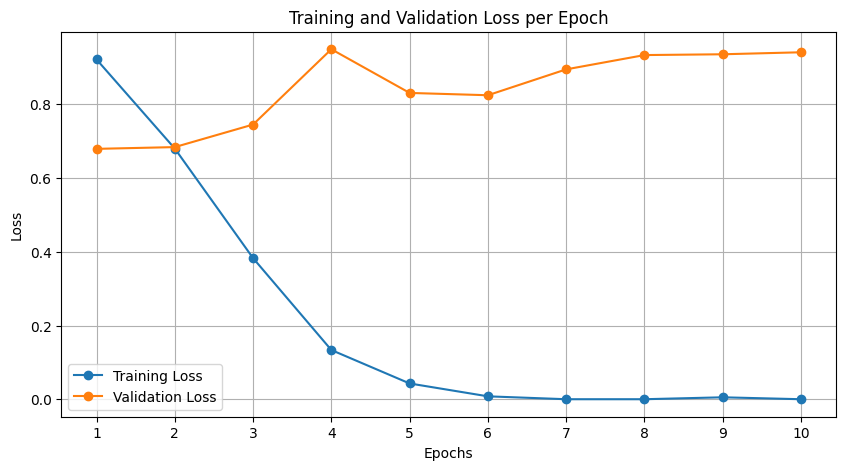

In [ ]:
# Extracting logs for visualization
log_history = trainer.state.log_history

# Initialize lists to store losses per epoch
train_losses = []
val_losses = []
epochs = []

# Initialize variables to track the current epoch
current_epoch = 0

# Iterate through log history to extract losses
for log in log_history:
    if 'loss' in log:
        # If we encounter a new epoch, append the average training loss
        if current_epoch < len(train_losses):
            train_losses[current_epoch] += log['loss']
        else:
            train_losses.append(log['loss'])
            epochs.append(current_epoch + 1)  # Store the epoch number
    if 'eval_loss' in log:
        # Append the validation loss for the current epoch
        val_losses.append(log['eval_loss'])
        current_epoch += 1  # Increment the epoch count after evaluation

# Average the training losses per epoch
train_losses = [loss / (len(log_history) // len(val_losses)) for loss in train_losses]

# Plotting the training and validation loss
plt.figure(figsize=(10, 5))
plt.plot(epochs, train_losses, label='Training Loss', marker='o')
plt.plot(range(1, len(val_losses) + 1), val_losses, label='Validation Loss', marker='o')
plt.title('Training and Validation Loss per Epoch')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.xticks(range(1, max(len(train_losses), len(val_losses)) + 1))  # Set x-ticks to be the epochs
plt.legend()
plt.grid()
plt.show()


## Evaluate the Model

In [ ]:
# Evaluate the Model
eval_results = trainer.evaluate()
print("Evaluation Results:", eval_results)

# Get Predictions
predictions, labels, _ = trainer.predict(val_dataset)
preds = np.argmax(predictions, axis=1)

Evaluation Results: {'eval_loss': 0.9411273002624512, 'eval_runtime': 2.364, 'eval_samples_per_second': 153.975, 'eval_steps_per_second': 38.494, 'epoch': 10.0}


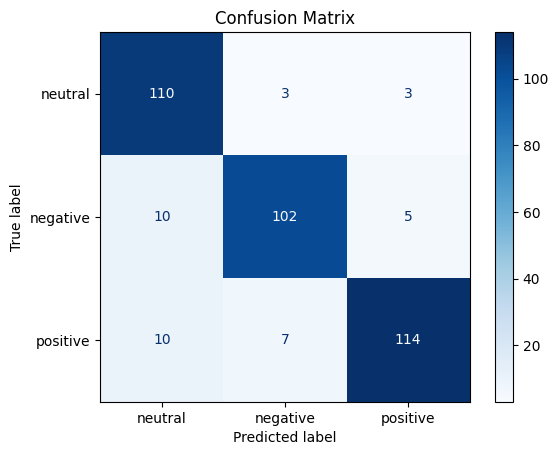

Accuracy: 0.8956
Precision: 0.8987
Recall: 0.8956
F1 Score: 0.8957


In [ ]:
# Step 7: Visualize the Results
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score, ConfusionMatrixDisplay

# Create confusion matrix
cm = confusion_matrix(labels, preds, labels=np.arange(len(polarity_labels)))

# Display confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=polarity_labels)
disp.plot(cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.show()

# Calculate metrics
accuracy = accuracy_score(labels, preds)
precision = precision_score(labels, preds, average='weighted')  # Use 'macro' or 'micro' as needed
recall = recall_score(labels, preds, average='weighted')        # Use 'macro' or 'micro' as needed
f1 = f1_score(labels, preds, average='weighted')                # Use 'macro' or 'micro' as needed

print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")

## Save the Fine-Tuned Model & Tokenizer

In [ ]:
# Save the model
trainer.save_model('./fine_tuned_model')  # Specify the directory where you want to save the model

# Optionally, save the tokenizer as well
tokenizer.save_pretrained('./fine_tuned_model')

('./fine_tuned_model/tokenizer_config.json',
 './fine_tuned_model/special_tokens_map.json',
 './fine_tuned_model/vocab.txt',
 './fine_tuned_model/added_tokens.json',
 './fine_tuned_model/tokenizer.json')

## Try to Predict with New Data

In [ ]:
from transformers import BertForSequenceClassification, AutoTokenizer
import torch

# Set up the device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Load the fine-tuned model and tokenizer
model = BertForSequenceClassification.from_pretrained('./fine_tuned_model')
tokenizer = AutoTokenizer.from_pretrained('./fine_tuned_model')

# Move model to the device
model.to(device)  # This line moves the model to the GPU

# Example laptop review sentences for prediction
sentences = [
    "This laptop has an incredible battery life; I can easily get through a full day of work without needing to recharge.",
    "The laptop overheats quickly, making it uncomfortable to use on my lap for extended periods.",
    "The laptop comes with 16GB of RAM and a 512GB SSD, which is standard for this price range.",
    "I love the sleek design and lightweight build of this laptop; it's perfect for traveling.",
    "The keyboard feels cheap and unresponsive, which makes typing a frustrating experience.",
    "The display is stunning with vibrant colors and sharp resolution; it's great for watching movies.",
    "I had to return the laptop because it arrived with a cracked screen, and the customer service was unhelpful.",
    "This model features an Intel i7 processor, which is suitable for most tasks.",
    "The sound quality from the speakers is surprisingly good for a laptop; I enjoy listening to music on it.",
    "The laptop is quite heavy, making it less portable than I expected."
]

# Tokenize the input sentences
inputs = tokenizer(sentences, padding=True, truncation=True, return_tensors='pt', max_length=128)

# Move inputs to the same device as the model
inputs = {key: val.to(device) for key, val in inputs.items()}

# Set the model to evaluation mode
model.eval()

# Make predictions
with torch.no_grad():
    outputs = model(**inputs)
    logits = outputs.logits  # Get the logits from the model output

# Get predicted class labels
predicted_class_ids = torch.argmax(logits, dim=1).cpu().numpy()  # Move predictions to CPU for numpy conversion

# Assuming you have a mapping from class IDs to class labels
id2polarity = {idx: label for idx, label in enumerate(polarity_labels)}

# Convert predicted class IDs to class labels
predicted_labels = [id2polarity[class_id] for class_id in predicted_class_ids]

# Print the results
for sentence, label in zip(sentences, predicted_labels):
    print(f"Sentence: '{sentence}' \n=> Predicted Label: '{label}'\n")

Sentence: 'This laptop has an incredible battery life; I can easily get through a full day of work without needing to recharge.' 
=> Predicted Label: 'positive'

Sentence: 'The laptop overheats quickly, making it uncomfortable to use on my lap for extended periods.' 
=> Predicted Label: 'negative'

Sentence: 'The laptop comes with 16GB of RAM and a 512GB SSD, which is standard for this price range.' 
=> Predicted Label: 'neutral'

Sentence: 'I love the sleek design and lightweight build of this laptop; it's perfect for traveling.' 
=> Predicted Label: 'positive'

Sentence: 'The keyboard feels cheap and unresponsive, which makes typing a frustrating experience.' 
=> Predicted Label: 'negative'

Sentence: 'The display is stunning with vibrant colors and sharp resolution; it's great for watching movies.' 
=> Predicted Label: 'positive'

Sentence: 'I had to return the laptop because it arrived with a cracked screen, and the customer service was unhelpful.' 
=> Predicted Label: 'negative'



# 🔬FINE-TUNING FOR ASPECT CLASSIFICATION

## Mapping the Data

In [ ]:
# Create label mappings for aspect
aspect_labels = df_balanced['aspect'].unique().tolist()
aspect2id = {label: idx for idx, label in enumerate(aspect_labels)}

# Map the aspect labels to their corresponding IDs
df_balanced['aspect_label'] = df_balanced['aspect'].map(aspect2id)

## Split Data

In [ ]:
# Split the dataset into train and validation sets
train_df, val_df = train_test_split(df_balanced, test_size=0.2, random_state=42)

## Tokenization

In [ ]:
from transformers import AutoTokenizer

# Load the tokenizer
tokenizer = AutoTokenizer.from_pretrained("bert-base-uncased")

# Tokenize the data
train_encodings = tokenizer(train_df['sentence'].tolist(), padding=True, truncation=True, return_tensors='pt', max_length=128)
val_encodings = tokenizer(val_df['sentence'].tolist(), padding=True, truncation=True, return_tensors='pt', max_length=128)

## Create Custom Dataset for Fine-Tuning

In [ ]:
import torch
from torch.utils.data import Dataset

class aspectDataset(Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels

    def __getitem__(self, idx):
        item = {key: val[idx] for key, val in self.encodings.items()}
        item['labels'] = self.labels[idx]
        return item

    def __len__(self):
        return len(self.labels)

# Create datasets
train_dataset = aspectDataset(train_encodings, train_df['aspect_label'].tolist())
val_dataset = aspectDataset(val_encodings, val_df['aspect_label'].tolist())

## Instantiate the Model

In [ ]:
from transformers import BertForSequenceClassification

# Initialize the model
num_labels = len(aspect_labels)
model = BertForSequenceClassification.from_pretrained("bert-base-uncased", num_labels=num_labels)

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


## Set The Training Parameters

In [ ]:
from transformers import Trainer, TrainingArguments

# Define training arguments
training_args = TrainingArguments(
    output_dir='./results',          # output directory
    num_train_epochs=10,              # total number of training epochs
    per_device_train_batch_size=4,   # batch size per device during training
    per_device_eval_batch_size=4,    # batch size for evaluation
    warmup_steps=500,                 # number of warmup steps for learning rate scheduler
    weight_decay=0.01,                # strength of weight decay
    logging_dir='./logs',            # directory for storing logs
    logging_steps=10,
    evaluation_strategy="epoch",     # evaluate every epoch
)

# Initialize the Trainer
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
)

/usr/local/lib/python3.10/dist-packages/transformers/training_args.py:1575: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


## Training the Model

In [ ]:
# Train the Model
trainer.train()

Epoch,Training Loss,Validation Loss
1,1.534700,1.366527
2,0.705900,0.599556
3,0.395500,0.682629
4,0.004600,0.747645
5,0.004600,0.663001
6,0.001400,0.666401
7,0.000800,0.691075
8,0.000700,0.686436
9,0.000800,0.645884
10,0.000600,0.672397


TrainOutput(global_step=3640, training_loss=0.3658552205127377, metrics={'train_runtime': 452.2135, 'train_samples_per_second': 32.153, 'train_steps_per_second': 8.049, 'total_flos': 642667859485440.0, 'train_loss': 0.3658552205127377, 'epoch': 10.0})

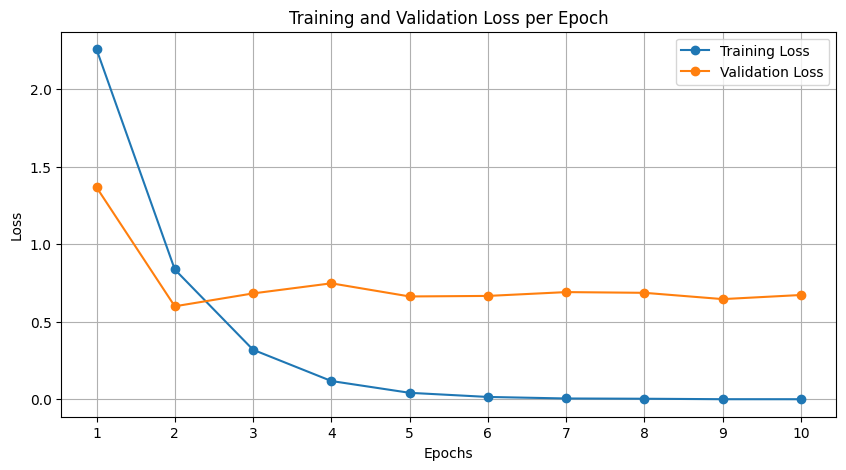

In [ ]:
# Extracting logs for visualization
log_history = trainer.state.log_history

# Initialize lists to store losses per epoch
train_losses = []
val_losses = []
epochs = []

# Initialize variables to track the current epoch
current_epoch = 0

# Iterate through log history to extract losses
for log in log_history:
    if 'loss' in log:
        # If we encounter a new epoch, append the average training loss
        if current_epoch < len(train_losses):
            train_losses[current_epoch] += log['loss']
        else:
            train_losses.append(log['loss'])
            epochs.append(current_epoch + 1)  # Store the epoch number
    if 'eval_loss' in log:
        # Append the validation loss for the current epoch
        val_losses.append(log['eval_loss'])
        current_epoch += 1  # Increment the epoch count after evaluation

# Average the training losses per epoch
train_losses = [loss / (len(log_history) // len(val_losses)) for loss in train_losses]

# Plotting the training and validation loss
plt.figure(figsize=(10, 5))
plt.plot(epochs, train_losses, label='Training Loss', marker='o')
plt.plot(range(1, len(val_losses) + 1), val_losses, label='Validation Loss', marker='o')
plt.title('Training and Validation Loss per Epoch')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.xticks(range(1, max(len(train_losses), len(val_losses)) + 1))  # Set x-ticks to be the epochs
plt.legend()
plt.grid()
plt.show()


## Evaluate the Model

In [ ]:
# Evaluate the Model
eval_results = trainer.evaluate()
print("Evaluation Results:", eval_results)

# Get Predictions
predictions, labels, _ = trainer.predict(val_dataset)
preds = np.argmax(predictions, axis=1)

Evaluation Results: {'eval_loss': 0.6723971366882324, 'eval_runtime': 1.7651, 'eval_samples_per_second': 206.216, 'eval_steps_per_second': 51.554, 'epoch': 10.0}


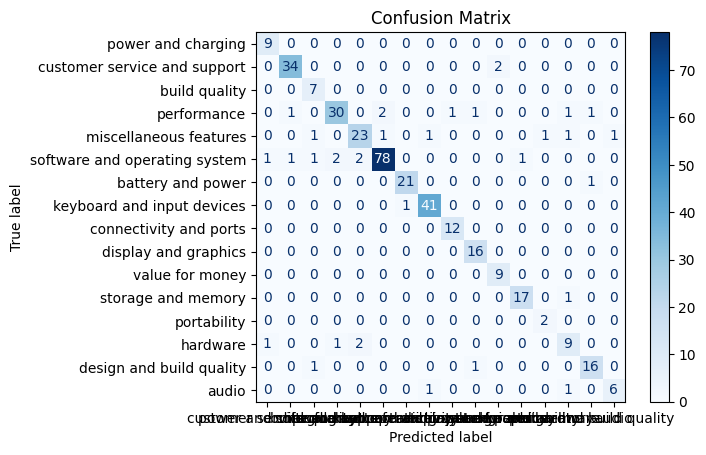

Accuracy: 0.9066
Precision: 0.9102
Recall: 0.9066
F1 Score: 0.9064


In [ ]:
# Step 7: Visualize the Results
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score, ConfusionMatrixDisplay

# Create confusion matrix
cm = confusion_matrix(labels, preds, labels=np.arange(len(aspect_labels)))

# Display confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=aspect_labels)
disp.plot(cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.show()

# Calculate metrics
accuracy = accuracy_score(labels, preds)
precision = precision_score(labels, preds, average='weighted')  # Use 'macro' or 'micro' as needed
recall = recall_score(labels, preds, average='weighted')        # Use 'macro' or 'micro' as needed
f1 = f1_score(labels, preds, average='weighted')                # Use 'macro' or 'micro' as needed

print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")

## Save the Fine-Tuned Model & Tokenizer

In [ ]:
# Save the model
trainer.save_model('./fine_tuned_model_aspect')  # Specify the directory where you want to save the model

# Optionally, save the tokenizer as well
tokenizer.save_pretrained('./fine_tuned_model_aspect')

('./fine_tuned_model_aspect/tokenizer_config.json',
 './fine_tuned_model_aspect/special_tokens_map.json',
 './fine_tuned_model_aspect/vocab.txt',
 './fine_tuned_model_aspect/added_tokens.json',
 './fine_tuned_model_aspect/tokenizer.json')

## Try to Predict with New Data

In [ ]:
from transformers import BertForSequenceClassification, AutoTokenizer
import torch

# Set up the device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Load the fine-tuned model and tokenizer
model = BertForSequenceClassification.from_pretrained('./fine_tuned_model_aspect')
tokenizer = AutoTokenizer.from_pretrained('./fine_tuned_model_aspect')

# Move model to the device
model.to(device)  # This line moves the model to the GPU

# Example laptop review sentences for prediction
sentences = [
    "This laptop has an incredible battery life; I can easily get through a full day of work without needing to recharge.",
    "The laptop overheats quickly, making it uncomfortable to use on my lap for extended periods.",
    "The laptop comes with 16GB of RAM and a 512GB SSD, which is standard for this price range.",
    "I love the sleek design and lightweight build of this laptop; it's perfect for traveling.",
    "The keyboard feels cheap and unresponsive, which makes typing a frustrating experience.",
    "The display is stunning with vibrant colors and sharp resolution; it's great for watching movies.",
    "I had to return the laptop because it arrived with a cracked screen, and the customer service was unhelpful.",
    "This model features an Intel i7 processor, which is suitable for most tasks.",
    "The sound quality from the speakers is surprisingly good for a laptop; I enjoy listening to music on it.",
    "The laptop is quite heavy, making it less portable than I expected."
]

# Tokenize the input sentences
inputs = tokenizer(sentences, padding=True, truncation=True, return_tensors='pt', max_length=128)

# Move inputs to the same device as the model
inputs = {key: val.to(device) for key, val in inputs.items()}

# Set the model to evaluation mode
model.eval()

# Make predictions
with torch.no_grad():
    outputs = model(**inputs)
    logits = outputs.logits  # Get the logits from the model output

# Get predicted class labels
predicted_class_ids = torch.argmax(logits, dim=1).cpu().numpy()  # Move predictions to CPU for numpy conversion

# Assuming you have a mapping from class IDs to class labels
id2aspect = {idx: label for idx, label in enumerate(aspect_labels)}

# Convert predicted class IDs to class labels
predicted_labels = [id2aspect[class_id] for class_id in predicted_class_ids]

# Print the results
for sentence, label in zip(sentences, predicted_labels):
    print(f"Sentence: '{sentence}' \n=> Predicted Aspect: '{label}'\n")

Sentence: 'This laptop has an incredible battery life; I can easily get through a full day of work without needing to recharge.' 
=> Predicted Aspect: 'battery and power'

Sentence: 'The laptop overheats quickly, making it uncomfortable to use on my lap for extended periods.' 
=> Predicted Aspect: 'miscellaneous features'

Sentence: 'The laptop comes with 16GB of RAM and a 512GB SSD, which is standard for this price range.' 
=> Predicted Aspect: 'storage and memory'

Sentence: 'I love the sleek design and lightweight build of this laptop; it's perfect for traveling.' 
=> Predicted Aspect: 'design and build quality'

Sentence: 'The keyboard feels cheap and unresponsive, which makes typing a frustrating experience.' 
=> Predicted Aspect: 'keyboard and input devices'

Sentence: 'The display is stunning with vibrant colors and sharp resolution; it's great for watching movies.' 
=> Predicted Aspect: 'display and graphics'

Sentence: 'I had to return the laptop because it arrived with a crac